In [43]:
import numpy as np
import pandas as pd

import re
import html
import json
import pickle

import nltk
import anago

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import LSTM, GRU, Activation, Dense, Dropout, Input, Embedding, MaxPooling1D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,  ModelCheckpoint

import seaborn as sn

In [18]:
data = pd.read_csv("dataset/tweets.csv")
data.head()

,user_id,tweet,label
0,66378098,[HARI PEREMPUAN INTERNASIONAL]\n\nHari Perempu...,0
1,66378098,Himasika mengucapkan selamat hari raya idul Ad...,0
2,66378098,[COMING SOON]\n\nHalo mahasiswa fisika!\nMusya...,0
3,66378098,[PENDAFTARAN BMS 2018 DIBUKA]\n\nPendaftaran B...,0
4,66378098,Persiapan hari ke 2 OKKBK Fisika ITS semangat ...,0


In [19]:
data['label'].value_counts()

0    1623
1     444
Name: label, dtype: int64

In [20]:
def clean_text_classification(text):
    text = text.lower()
    
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r'#[A-Za-z0-9]+', ' ', text)
    text = re.sub(r'\w+:\/\/\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    text = re.sub(r' +', ' ', text)
    
    return ' '.join(text.split())

In [21]:
def clean_text_ner(text):
    
    text = html.unescape(text)
    text = re.sub(r'#[A-Za-z0-9]+', ' ', text)
    text = re.sub(r'\w+:\/\/\S+', ' ', text)
    
    text = re.sub(r' +', ' ', text)
    
    return ' '.join(text.split())

In [22]:
def replace_slang(text, acronym):
    res = []
    
    for w in text.split(' '):
        if w in acronym:
            res.append(acronym[w])
        else:
            res.append(w)
    
    return ' '.join(res)

In [23]:
def stemming(text, stemmer):
    stem_text = stemmer.stem(text)
    return stem_text

In [24]:
with open("extra/akronim.json", "r") as f:    
    acronym_map = json.load(f)

In [25]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [26]:
data['tweet_clf'] = data['tweet'].apply(lambda x: clean_text_classification(x))
data['tweet_clf'] = data['tweet_clf'].apply(lambda x: replace_slang(x, acronym_map))
data['tweet_clf'] = data['tweet_clf'].apply(lambda x: stemming(x, stemmer))

In [27]:
data['tweet_ner'] = data['tweet'].apply(lambda x: clean_text_ner(x))
data['tweet_ner'] = data['tweet_ner'].apply(lambda x: replace_slang(x, acronym_map))

In [34]:
data = pd.read_csv("dataset/tweet_preprocessed.csv")
data.head()

,user_id,tweet,label,tweet_clf,tweet_ner
0,66378098,[HARI PEREMPUAN INTERNASIONAL]\n\nHari Perempu...,0,hari perempuan internasional hari perempuan in...,[HARI PEREMPUAN INTERNASIONAL] Hari Perempuan ...
1,66378098,Himasika mengucapkan selamat hari raya idul Ad...,0,himasika ucap selamat hari raya idul adha 1436...,Himasika mengucapkan selamat hari raya idul Ad...
2,66378098,[COMING SOON]\n\nHalo mahasiswa fisika!\nMusya...,0,coming soon halo mahasiswa fisika musyawarah a...,[COMING SOON] Halo mahasiswa fisika! Musyawara...
3,66378098,[PENDAFTARAN BMS 2018 DIBUKA]\n\nPendaftaran B...,0,daftar bms 2018 buka daftar bms 2018 himasika ...,[PENDAFTARAN BMS 2018 DIBUKA] Pendaftaran BMS ...
4,66378098,Persiapan hari ke 2 OKKBK Fisika ITS semangat ...,0,siap hari ke 2 okkbk fisika its semangat adek2...,Persiapan hari ke 2 OKKBK Fisika ITS semangat ...


In [37]:
data_x = data['tweet_clf']
data_y = data['label']

In [35]:
max_words = 3000
max_len = 50

In [38]:
tok = Tokenizer(num_words=max_words, lower=True)
tok.fit_on_texts(data_x)

sequences = tok.texts_to_sequences(data_x)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [40]:
with open('extra/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
def rnn_model():
    model = Sequential()
    
    model.add(Embedding(max_words, 32, input_length=max_len))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    return model

In [56]:
model = rnn_model()

filepath="weights-best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=3)
callback = [checkpoint, earlystop]

model.fit(sequences_matrix, data_y, 
          batch_size=100, epochs=30, verbose=1, 
          validation_split=0.2, 
          callbacks=callback)

model.load_weights(filepath=filepath)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 32)            96000     
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 32)            8320      
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________
None

In [120]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [121]:
ans = model.evaluate(test_sequences_matrix, Y_test)

517/517 [==============================] - 0s 281us/step


In [122]:
print('Test set\nLoss: {:0.3f}\nAccuracy: {:0.3f}'.format(ans[0], ans[1]))

Test set
Loss: 0.533
Accuracy: 0.892


In [57]:
model = rnn_model()
model.load_weights(filepath=filepath)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 32)            96000     
_________________________________________________________________
lstm_15 (LSTM)               (None, 50, 32)            8320      
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________
None

In [59]:
with open('extra/tokenizer.pickle', 'rb') as handle:
    tok = pickle.load(handle)

In [66]:
test_sequences = tok.texts_to_sequences(["physicsday ayo masyarakat fisika diri dan suara untuk dukung futsal fisika senin 18 maret 2019 19 30 gor pertamina its blackwolf hitam kerudung hitam 5k"])
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [67]:
y_pred = model.predict_classes(test_sequences_matrix)

In [74]:
y_pred[0][0]

1

In [68]:
test_sequences_matrix

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 2903,   63,  260,  389,  107,    4,  712,    7,
         373,  597,  389,  259,  150,  230,   25,  160,   78,  390,  439,
           2, 2904, 2001, 2905, 2001, 2906]], dtype=int32)

In [69]:
y_pred = model.predict_classes(test_sequences_matrix)

In [70]:
y_pred

array([[1]], dtype=int32)

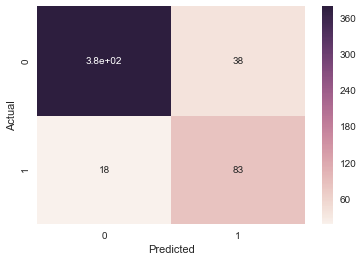

In [126]:
cfm = {'y_pred': y_pred.reshape(517), 'y_true': Y_test.values}
cfm_df = pd.DataFrame(cfm)
confusion_matrix = pd.crosstab(cfm_df['y_pred'], cfm_df['y_true'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)

In [127]:
from sklearn.metrics import classification_report

In [129]:
print(classification_report(Y_test, y_pred, target_names=['non-event', 'event']))

              precision    recall  f1-score   support

   non-event       0.91      0.95      0.93       396
       event       0.82      0.69      0.75       121

    accuracy                           0.89       517
   macro avg       0.87      0.82      0.84       517
weighted avg       0.89      0.89      0.89       517



#### NER

In [74]:
data = pd.read_csv("dataset/tweet_preprocessed.csv")

In [90]:
def get_ner_label(text):
    text = re.sub(r'\t.+?\n', '', text)
    
    cur_label = re.findall("TYPE=\"(.+?)\">(.+?)<", text)
    dict_label = dict((y, x) for x, y in cur_label)
    
    
    print(dict_label)
    
    text = ' '.join(re.split('<ENAMEX.+?>|</ENAMEX>| ', text))
    data = re.findall(r"[\w']+|[!\"#$%&\(\)*+,-./:;<=>?@\[\\\]\^_`\{\|\}~]", text)

    label = []
    
    for w in data:
        if w in dict_label:
            if(len(label) > 0 and label[-1][2:] == w):
                label.append('I-' + dict_label[w][:3])
            else:
                label.append('B-' + dict_label[w][:3])
        else:
            label.append('O')
    
    return data, label

In [92]:
get_ner_label(ner_train[24])

{'Timtas Tipikor': 'ORGANIZATION', 'Hendarman Supandji': 'PERSON', 'Kejaksaan Agung': 'ORGANIZATION', 'Kejagung': 'ORGANIZATION', 'Jl Hasanuddin': 'LOCATION', 'Jakarta Selatan': 'LOCATION'}


(['Baik',
  'itu',
  'pidana',
  'umum',
  'maupun',
  'korupsi',
  ',',
  '"',
  'ujar',
  'Ketua',
  'Timtas',
  'Tipikor',
  'Hendarman',
  'Supandji',
  'di',
  'Kantor',
  'Kejaksaan',
  'Agung',
  '(',
  'Kejagung',
  ')',
  ',',
  'Jl',
  'Hasanuddin',
  ',',
  'Jakarta',
  'Selatan',
  ',',
  'Selasa',
  '(',
  '14',
  '/',
  '6',
  '/',
  '2005',
  ')',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-ORG',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'])

In [76]:
ner_train = tuple(open("ner/training_data.txt", 'r'))
ner_valid = tuple(open("ner/testing_data.txt", 'r'))

In [77]:
train_x = []
train_y = []
valid_x = []
valid_y = []

In [89]:
print(train_x[24])
print(train_y[24])

['Baik', 'itu', 'pidana', 'umum', 'maupun', 'korupsi', ',', '"', 'ujar', 'Ketua', 'Timtas', 'Tipikor', 'Hendarman', 'Supandji', 'di', 'Kantor', 'Kejaksaan', 'Agung', '(', 'Kejagung', ')', ',', 'Jl', 'Hasanuddin', ',', 'Jakarta', 'Selatan', ',', 'Selasa', '(', '14', '/', '6', '/', '2005', ')', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [81]:
list_tag = []

In [82]:
for x in valid_y:
    for y in x:
        list_tag.append(y)

In [83]:
list_tag = list(set(list_tag))

In [84]:
list_tag

['B-LOC', 'B-ORG', 'O', 'B-PER']

In [78]:
for t in ner_train:
    x, y = get_ner_label(t)
    train_x.append(x)
    train_y.append(y)

for t in ner_valid:
    x, y = get_ner_label(t)
    valid_x.append(x)
    valid_y.append(y)

In [79]:
train_x = np.array(train_x)
train_y = np.array(train_y)

valid_x = np.array(valid_x)
valid_y = np.array(valid_y)

In [63]:
train_y[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
data[data]

In [60]:
data[data['label'] == 1]['tweet_clf'].iloc[1]

'physicsday ayo masyarakat fisika diri dan suara untuk dukung futsal fisika senin 18 maret 2019 19 30 gor pertamina its blackwolf hitam kerudung hitam 5k'

In [65]:
model = anago.Sequence(char_emb_size=25, word_emb_size=100, char_lstm_units=25,
                       word_lstm_units=100, dropout=0.5, char_feature=True, crf=True,
                       batch_size=20, optimizer='adam', learning_rate=0.001,lr_decay=0.9,
                       clip_gradients=5.0, max_epoch=30, early_stopping=True, patience=3,
                       train_embeddings=True, max_checkpoints_to_keep=5, log_dir=None)
 
model.train(train_x, train_y, valid_x, valid_y)


Epoch 1/30
85/85 [==============================] - 13s 152ms/step - loss: 43.2423
 - f1: 0.00
Epoch 2/30
85/85 [==============================] - 9s 105ms/step - loss: 38.9473
 - f1: 28.16
Epoch 3/30
85/85 [==============================] - 9s 110ms/step - loss: 36.7616
 - f1: 45.65
Epoch 4/30
85/85 [==============================] - 12s 144ms/step - loss: 36.6839
 - f1: 67.40
Epoch 5/30
85/85 [==============================] - 11s 131ms/step - loss: 35.9724
 - f1: 74.45
Epoch 6/30
85/85 [==============================] - 11s 126ms/step - loss: 33.5540
 - f1: 75.80
Epoch 7/30
85/85 [==============================] - 10s 122ms/step - loss: 34.6197
 - f1: 76.06
Epoch 8/30
85/85 [==============================] - 13s 152ms/step - loss: 34.5161
 - f1: 76.70
Epoch 9/30
85/85 [==============================] - 12s 137ms/step - loss: 34.7273
 - f1: 74.90
Epoch 10/30
85/85 [==============================] - 14s 161ms/step - loss: 34.1694
 - f1: 77.83
Epoch 11/30
85/85 [=======================

In [66]:
words = 'Welcome Party UKM Robotika ITS, Kamis 2-10-2014 @Hall Pusat Robotika ITS, ayo datang & ramaikan temen2 anggota baru'
words = re.findall(r"[\w']+|[!\"#$%&\(\)*+,-./:;<=>?@\[\\\]\^_`\{\|\}~]", words)

In [67]:
model.analyze(words)

{'words': ['Welcome',
  'Party',
  'UKM',
  'Robotika',
  'ITS',
  ',',
  'Kamis',
  '2',
  '-',
  '10',
  '-',
  '2014',
  '@',
  'Hall',
  'Pusat',
  'Robotika',
  'ITS',
  ',',
  'ayo',
  'datang',
  '&',
  'ramaikan',
  'temen2',
  'anggota',
  'baru'],
 'entities': [{'text': 'ITS',
   'type': 'LOC',
   'score': 1.0,
   'beginOffset': 4,
   'endOffset': 5}]}

In [20]:
import gensim
 
embeddings = gensim.models.Word2Vec.load("w2vec_wiki_id_case")
model = anago.Sequence(char_emb_size=50, word_emb_size=400, char_lstm_units=50,
                       word_lstm_units=400, dropout=0.5, char_feature=True, crf=True,
                       batch_size=20, optimizer='adam', learning_rate=0.001,lr_decay=0.9,
                       clip_gradients=5.0, max_epoch=30, early_stopping=True, patience=3,
                       train_embeddings=True, max_checkpoints_to_keep=5, log_dir=None, embeddings=embeddings)

In [21]:
model.train(train_x, train_y, valid_x, valid_y)

Epoch 1/30
85/85 [==============================] - 65s 763ms/step - loss: 40.4386
 - f1: 50.25
Epoch 2/30
85/85 [==============================] - 62s 724ms/step - loss: 36.2340
 - f1: 75.82
Epoch 3/30
85/85 [==============================] - 62s 731ms/step - loss: 34.2896
 - f1: 76.59
Epoch 4/30
85/85 [==============================] - 65s 760ms/step - loss: 35.5978
 - f1: 77.92
Epoch 5/30
85/85 [==============================] - 62s 731ms/step - loss: 34.8621
 - f1: 77.74
Epoch 6/30
85/85 [==============================] - 58s 677ms/step - loss: 33.1736
 - f1: 77.62
Epoch 7/30
85/85 [==============================] - 59s 692ms/step - loss: 35.5635
 - f1: 77.22


In [14]:
model.analyze(words)

{'words': ['Welcome',
  'Party',
  'UKM',
  'Robotika',
  'ITS',
  ',',
  'Kamis',
  '2',
  '-',
  '10',
  '-',
  '2014',
  '@',
  'Hall',
  'Pusat',
  'Robotika',
  'ITS',
  ',',
  'ayo',
  'datang',
  '&',
  'ramaikan',
  'temen2',
  'anggota',
  'baru'],
 'entities': []}

In [17]:
embeddings = gensim.models.KeyedVectors.load_word2vec_format("w2vec_glove_wiki_id.txt")
model = anago.Sequence(char_emb_size=25, word_emb_size=50, char_lstm_units=25,
                       word_lstm_units=50, dropout=0.5, char_feature=True, crf=True,
                       batch_size=20, optimizer='adam', learning_rate=0.001,lr_decay=0.9,
                       clip_gradients=5.0, max_epoch=30, early_stopping=True, patience=3,
                       train_embeddings=True, max_checkpoints_to_keep=5, log_dir=None, embeddings=embeddings)

In [18]:
model.train(train_x, train_y, valid_x, valid_y)

Epoch 1/30
85/85 [==============================] - 13s 154ms/step - loss: 42.6788
 - f1: 0.00
Epoch 2/30
85/85 [==============================] - 9s 108ms/step - loss: 39.7868
 - f1: 5.86
Epoch 3/30
85/85 [==============================] - 12s 137ms/step - loss: 38.7313
 - f1: 32.09
Epoch 4/30
85/85 [==============================] - 9s 111ms/step - loss: 36.7381
 - f1: 56.82
Epoch 5/30
85/85 [==============================] - 10s 112ms/step - loss: 37.0301
 - f1: 59.21
Epoch 6/30
85/85 [==============================] - 9s 111ms/step - loss: 37.3725
 - f1: 72.03
Epoch 7/30
85/85 [==============================] - 12s 136ms/step - loss: 37.5831
 - f1: 71.27
Epoch 8/30
85/85 [==============================] - 10s 115ms/step - loss: 36.5990
 - f1: 77.69
Epoch 9/30
85/85 [==============================] - 10s 112ms/step - loss: 36.3398
 - f1: 77.06
Epoch 10/30
85/85 [==============================] - 10s 119ms/step - loss: 34.9243
 - f1: 81.32
Epoch 11/30
85/85 [=========================

In [19]:
model.analyze(words)

{'words': ['Welcome',
  'Party',
  'UKM',
  'Robotika',
  'ITS',
  ',',
  'Kamis',
  '2',
  '-',
  '10',
  '-',
  '2014',
  '@',
  'Hall',
  'Pusat',
  'Robotika',
  'ITS',
  ',',
  'ayo',
  'datang',
  '&',
  'ramaikan',
  'temen2',
  'anggota',
  'baru'],
 'entities': []}

In [1]:
from bs4 import BeautifulSoup

In [2]:
with open("extra/map.osm") as fp:
    soup = BeautifulSoup(fp)

In [7]:
tags = soup.findAll('tag')

for tag in tags:
    if str(tag['k']) == 'name':
        print(str(tag['v']))

Bundaran ITS
Bank Mandiri
BNI
BRI
Monumen Titik Nol ITS
Parkir Perpustakaan ITS
Panjat Dinding ITS
PENS
Apartemen Puncak Kertajaya
kertajaya indah
Blok T
Sate Kambing & Gulai Keputih
Sego Njamoer
Jalan Kertajaya Indah Timur XVIII
Fotokopi + Print TMB
BTS
Pondok Pesantren Muhyiddin
Masjid Ahmad Yani
Masjid Ahmad Yani
Mushola An-Nahl
Musholah dewa ruci
Masjid Bahrul Ulum PPNS
Cafetaria Informatika
Jalan Kejawan Putih Tambak
Jalan KH. Ahmad Dahlan
Jl. Teknik Sipil
Jalan Teknik Elektro
Graha Sepuluh Nopember
Perpustakaan ITS
taman sipil
D3 Mesin
Sistem Informasi
Mushola SI
Gebang Kidul
REKTORAT
UPT Bahasa
Asrama PENS-ITS
Asrama PENS-ITS
Asrama PENS-ITS
Lapangan Futsal Teknik Sipil
Parkir mobil dinas
Lapangan futsal
Gedung D3 (Teknik Mesin, Elektro, Kimia)
Kantor Satuan Keamanan Kampus
Puskom
Lab Bahasa
Kimia
UPMS
Jurusan Arsitektur ITS
Masjid Manarul Ilmi
SCC
BAUK ITS
Informatika
Gedung Nasdec ITS
Lab Pengembangan Teknologi Hidrodinamika
Rektorat PPNS
Asrama ITS
Parkir asrama
Despro
Asrama

In [22]:
places = []

In [23]:
with open('extra/Gazetteer.txt') as f:
    lines = f.readlines()
    for line in lines:
        places.append(line[:-1])

In [26]:
places = list(set(places))

In [27]:
len(places)

292

In [28]:
with open("Gazetteer.txt", "w") as f:
    for p in places:
        f.write(p + '\n')